# Documentation
* [UKBiobank online browser](https://biobank.ndph.ox.ac.uk/showcase/)
* [UKBiobank intro doc](https://biobank.ndph.ox.ac.uk/showcase/ukb/exinfo/ShowcaseUserGuide.pdf)
* Our Wiki: https://github.com/ritterlab/deepMRI/wiki/UKBiobank_extended2020 

Author: Roshan Rane<br>
Date: Feb 2022<br>
A newer version of UKBiobank data was downloaded in 2020-21 by Alexander Koch and Marc-Andre Schulz.<br>
This statistics script is adapted from Sudeshna Bora's lab rotation analysis. <br>


# Import libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from glob import glob
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=False)
import json
from tqdm.notebook import tqdm

In [3]:
from ukbb2020_dataloader import UKBB2020

In [4]:
sys.path.insert(0, "../../helper/")
from plotGraphs import *

In [5]:
DATA_DIR = "/ritter/share/data/UKBB_2020"

# prepare `participants.csv` 
1. from `ukb44573.csv` extract only subjects that are downloaded in BIDS dir
2. extract basic `demographic` information
3. determine the `path`  location of the T1, T2, T1_to_MNI images
4. tag some part of the data as `holdout` split

In [7]:
# subs = {}

# for sub in tqdm(os.listdir(f'{DATA_DIR}/BIDS')):
#     if os.path.isdir(join(f'{DATA_DIR}/BIDS', sub)) and "sub-" in sub:
#         subID = int(sub.replace("sub-", ''))
#         subs.update({subID : {
#                               'path_T1': np.nan,
#                               'path_T1_raw': np.nan,
#                               'path_T1_MNI': np.nan,
#                               'path_T2_FLAIR': np.nan,
#                               'path_T2_FLAIR_raw': np.nan,
#                               'path_T2_FLAIR_MNI': np.nan,
#                               'path_T1_brain_mask': np.nan}})
        
#         for img_typ in ['T1_brain', 'T1_orig_defaced', 'T1_brain_to_MNI', 
#                         'T2_FLAIR_brain',  'T2_FLAIR_orig_defaced', 'T2_FLAIR_brain_to_MNI', 
#                         'T1_brain_mask']:
            
#             filepath = f'sub-{str(subID)}/ses-2/anat/sub-{str(subID)}_ses-2_{img_typ}.nii.gz'
            
#             if os.path.isfile(f'{DATA_DIR}/BIDS/'+filepath):
#                 # map file suffixes to intended colnames
#                 colname = 'path_' + img_typ.replace('_orig_defaced', '_raw'
#                                                 ).replace('_brain',''
#                                                  ).replace('_to',''
#                                                   ).replace('T1_mask','T1_brain_mask'
#                                                    )
#                 subs[subID][colname] = filepath

# #     break
# # display(subs)
# df = pd.DataFrame(subs).T
# df.index.rename('subjectID', inplace=True)
# df['session'] = 'ses-2'
# # drop empty rows
# # df = df.drop(df[df.isna().all(axis=1)].index)
# df.sort_index().to_csv(DATA_DIR+"/BIDS/participants.csv")

Total subjects in /ritter/share/data/UKBB_2020/BIDS/: 40682


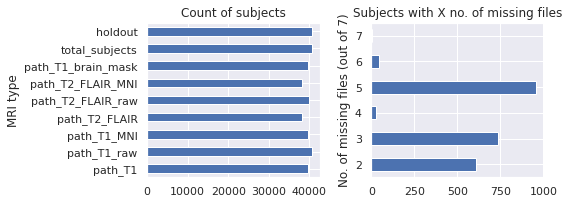

2375 subjects are missing at least 1 of the 7 imaging files...


In [6]:
df = pd.read_csv(DATA_DIR+"/BIDS/participants.csv", index_col='subjectID')
print("Total subjects in {}: {}".format(DATA_DIR+'/BIDS/', len(df)))

f, axes = plt.subplots(1,2, figsize=(8,3))

df.rename(columns={'session': 'total_subjects'}).count().plot.barh(
                                                            ax=axes[0],
                                                            title="Count of subjects",
                                                            ylabel="number of subjects", 
                                                            xlabel="MRI type")

missing_rows = df[df.isna().any(1)]
missing_rows.isna().sum(1).value_counts().sort_index().plot.barh(
    ax=axes[1],
    title="Subjects with X no. of missing files",
    ylabel="number of subjects", xlabel="No. of missing files (out of 7)")

plt.tight_layout()
plt.show()

print("{} subjects are missing at least 1 of the 7 imaging files...".format(len(missing_rows)))

In [9]:
df.columns

Index(['path_T1', 'path_T1_raw', 'path_T1_MNI', 'path_T2_FLAIR',
       'path_T2_FLAIR_raw', 'path_T2_FLAIR_MNI', 'path_T1_brain_mask',
       'session', 'holdout'],
      dtype='object')

In [10]:
df.holdout.value_counts()

False    30593
True     10089
Name: holdout, dtype: int64

### extract the subset of meta data
To extract the subset `sourceData_40682.csv` from the larger `ukb44573.csv` run the script `tools/filter_ukb44573csv.py`

In [10]:
with open("columns.json", "r") as fp:
    all_col_codes = json.load(fp)
print("total meta_data columns = {} for the subjects in participants.csv".format(len(all_col_codes)))

total meta_data columns = 20493 for the subjects in participants.csv


### How to read meta data columns ?
column IDs of interest may be found from https://biobank.ndph.ox.ac.uk/showcase/search.cgi

In [11]:
# load the meta data's dict file that maps all column codes to actual information
col_dict = pd.read_csv(DATA_DIR+"/tables/Data_Dictionary_Showcase.tsv", encoding="ISO-8859-1", sep='\t')

usecols = ['31-0.0','21003-2.0','1558-2.0','20403-0.0','20406-0.0','20404-0.0','20416-0.0',
           '20414-0.0', '20117-2.0','20408-0.0','20412-0.0','20415-0.0', 
#            '1707-2.0', '189-0.0', '21001-2.0', '25005-2.0', '25007-2.0',
#            '4080-2.0', '6138-2.1', '6138-2.2', '3456-2.0', '22508-0.0', 
#            '20115-0.0', '4079-2.1', '4080-2.1', '54-2.0', '30730-1.0', 
#            '22040-0.0', '6138-2.4', '22506-0.0', '6138-2.3', '1239-2.0', 
#            '6138-2.0', '21000-0.0', '30690-1.0', '4079-2.0', '6138-2.5'
          ]

fieldIDs = []
for col in usecols: fieldIDs.extend([int(col.split('-')[0])])
col_dict.loc[col_dict.FieldID.isin(fieldIDs), : ].head(2) # ['FieldID','Field','Notes']

,Path,Category,FieldID,Field,Participants,Items,Stability,ValueType,Units,ItemType,Strata,Sexed,Instances,Array,Coding,Notes,Link
7,Population characteristics > Baseline characte...,100094,31,Sex,502414,502414,Complete,Categorical single,NaN,Data,Primary,Unisex,1,1,9.0,Sex of participant. Acquired from central reg...,http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=31
150,Assessment Centre > Touchscreen > Lifestyle an...,100051,1558,Alcohol intake frequency.,501534,576792,Complete,Categorical single,NaN,Data,Primary,Unisex,4,1,100402.0,"ACE touchscreen question ""About how often do y...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=...


In [12]:
# read data encoding
# df_dict_codes = pd.read_csv(DATA_DIR+"/tables/Codings.tsv", encoding="ISO-8859-1", sep='\t',
#                                                  index_col=["Coding", "Value"], usecols=["Coding","Value", "Meaning"])
# df_dict_codes

### create holdout
setting aside all subjects from the site `Newcastle` as the holdout

In [13]:
# dataset = UKBB2020()
# df_meta = dataset.get_metadata(predefined=[], cols=["54-2.0"]) 
# df['holdout'] = False
# subs_for_holdout = df_meta[df_meta['UK Biobank assessment centre'] == 'Newcastle (imaging)'].index
# df.loc[subs_for_holdout, 'holdout'] = True
# df.sort_index().to_csv(DATA_DIR+"/BIDS/participants.csv")

# Statistics 

## Socio-demographics 
Category 701 in UK Biobank: https://biobank.ndph.ox.ac.uk/showcase/label.cgi?id=701

In [16]:
dataset = UKBB2020()
df = dataset.get_metadata(predefined=['demographics', 'socioeconomic'], cols=[])

total subjects in df: 40682
loaded following columns:
 {'31-0.0': 'Sex (s0.0)', '21003-2.0': 'Age when attended assessment centre', '21022-0.0': 'Age at recruitment (s0.0)', '54-2.0': 'UK Biobank assessment centre', '1707-0.0': 'Handedness (chirality/laterality) (s0.0)', '189-0.0': 'Townsend deprivation index at recruitment (s0.0)', '20115-0.0': 'Country of Birth (non-UK origin) (s0.0)', '21000-0.0': 'Ethnic background (s0.0)', '738-2.0': 'Average total household income before tax', '6142-2.0': 'Current employment status', '6142-0.0': 'Current employment status (s0.0)', '26410-0.0': 'Index of Multiple Deprivation (England) (s0.0)', '26427-0.0': 'Index of Multiple Deprivation (Scotland) (s0.0)', '26426-0.0': 'Index of Multiple Deprivation (Wales) (s0.0)'}


### Demographics

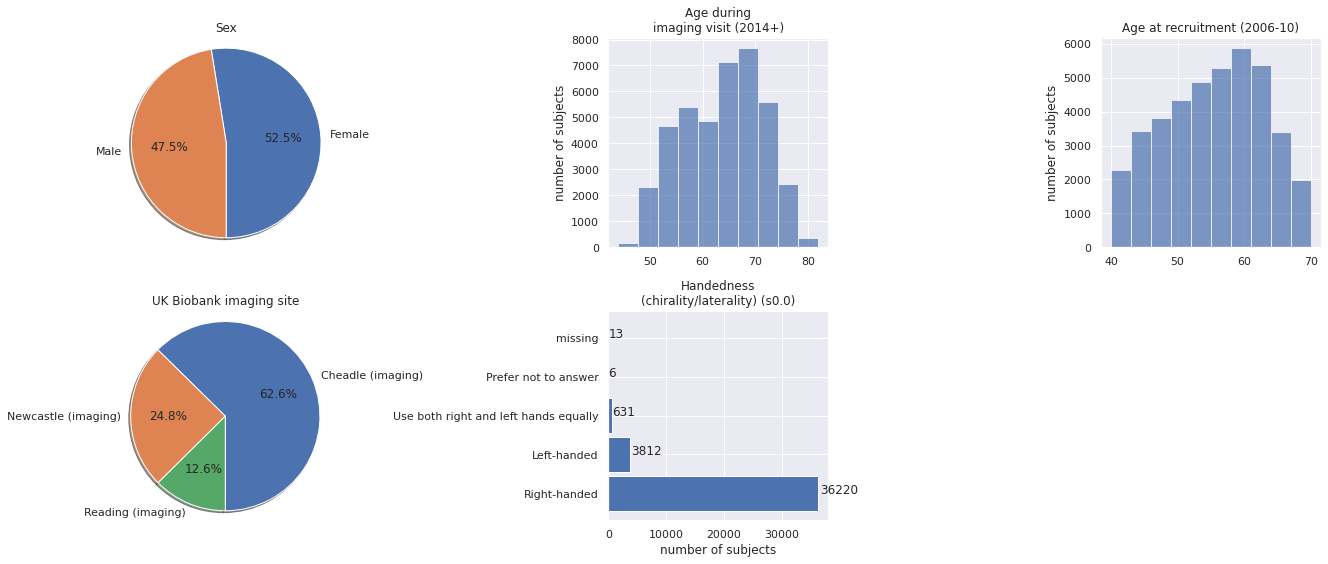

In [15]:
cols_to_plt = {'Sex (s0.0)': 'Sex',
             'Age when attended assessment centre': 'Age during imaging visit (2014+)',
             'Age at recruitment (s0.0)': 'Age at recruitment (2006-10)',
             'UK Biobank assessment centre': 'UK Biobank imaging site', 
             'Handedness (chirality/laterality) (s0.0)': 'Handedness (chirality/laterality) (s0.0)'}

df_demo = df[list(cols_to_plt.keys())].rename(columns=cols_to_plt)
dataset.plot_metadata(df_demo)
plt.show()

Demographic distributions across the 3 sites:

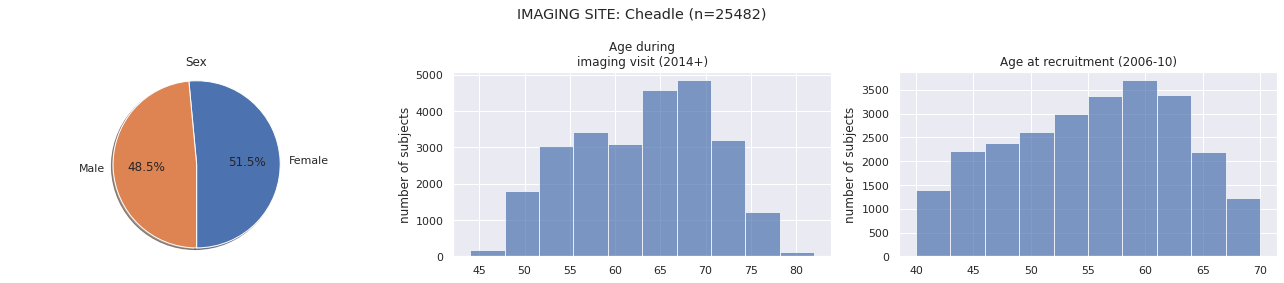

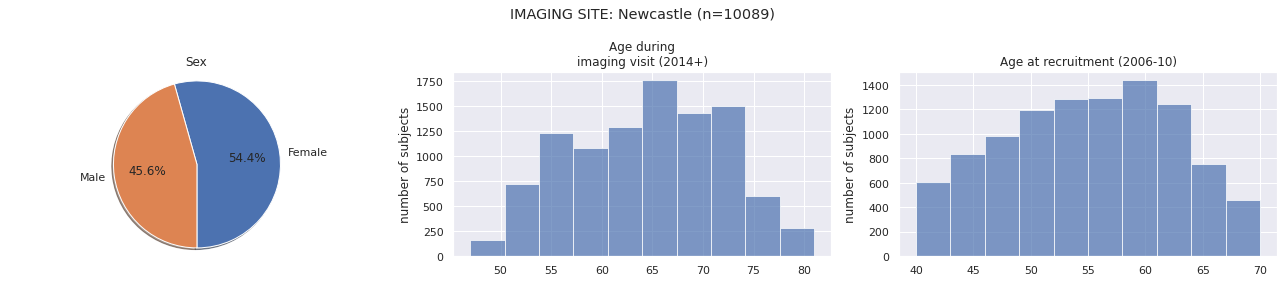

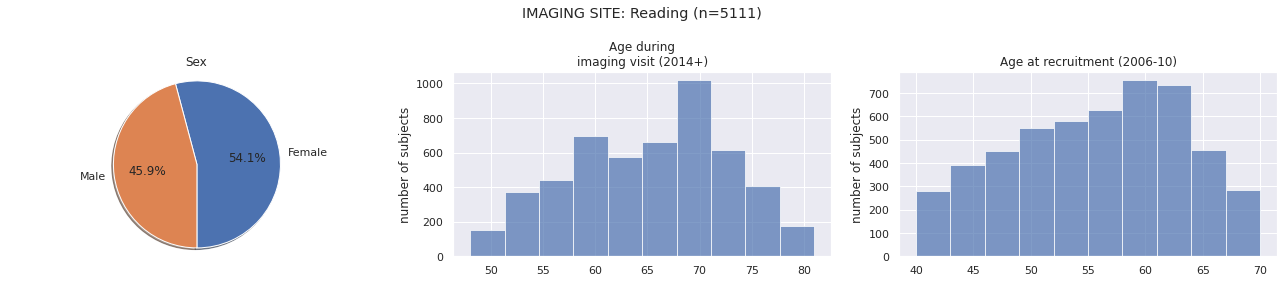

In [16]:
for site, group in df_demo.groupby('UK Biobank imaging site'): 
    if site!='missing':
        dataset.plot_metadata(group.drop(columns=['UK Biobank imaging site', 'Handedness (chirality/laterality) (s0.0)']))
        plt.suptitle(f"IMAGING SITE: {site.split(' ')[0]} (n={len(group)})")
        plt.tight_layout()
        plt.show()

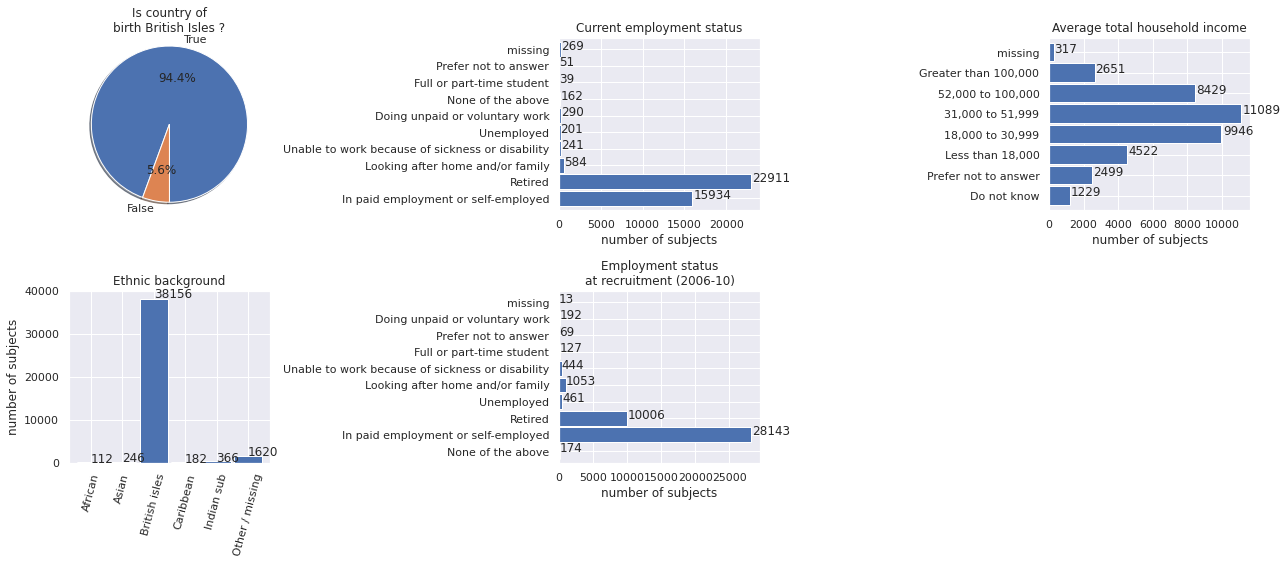

In [17]:
# change to a 'Country of Birth (non-UK origin)' and 'Ethnic background' to binary
df['Country of Birth bool (s0.0)'] = df['Country of Birth (non-UK origin) (s0.0)'].apply(
    lambda x: True if (x in ['missing', 'United Kingdom','Isle of Man','Ireland']) else False).astype(bool)

df['Ethnic background cat (s0.0)'] = df['Ethnic background (s0.0)'].apply(
    lambda x: "British isles" if (x in ['British', 'Irish']) else (
                "Indian sub" if (x in ['Indian','Pakistani','Bangladeshi']) else (
                    "Caribbean" if "Caribbean" in x else(
                        'African' if x=='African' else(
                            'Asian' if 'Asian' in x or x=='Chinese' else(
                                "Other / missing"))))))

cols_to_plt = {
             'Country of Birth bool (s0.0)': 'Is country of birth British Isles ?',
             'Current employment status': 'Current employment status', 
             'Average total household income before tax': 'Average total household income',
             'Ethnic background cat (s0.0)': 'Ethnic background', 
             'Current employment status (s0.0)': 'Employment status at recruitment (2006-10)'}

#plot
dataset.plot_metadata(df[list(cols_to_plt.keys())].rename(columns=cols_to_plt))
plt.show()

### Social deprivations

**Description for Index of Multiple Deprivation index:** <br>
 - Multiple Deprivation index is generated using  7-9 distinct domains like Income Deprivation, Employment Deprivation, Health Deprivation and Disability, Education Skills and Training Deprivation, Barriers to Housing and Services, Living Environment Deprivation, and Crime. 
 - England, Scotland and Wales have different measurement standards, hence they are shown separately.
 - More info: https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=26410 and https://biobank.ndph.ox.ac.uk/showcase/label.cgi?id=76 <br>
 - Individual domains can be used in isolation as measures of each specific form of deprivation using cols ['26433-0.0', '26422-0.0','26425-0.0', '26416-0.0', '26434-0.0', '26414-0.0', '26431-0.0', '26421-0.0', '26412-0.0', '26429-0.0', '26419-0.0', '26413-0.0', '26430-0.0', '26420-0.0', '26415-0.0', '26432-0.0', '26423-0.0', '26411-0.0', '26428-0.0', '26418-0.0', '26410-0.0', '26427-0.0', '26426-0.0', '26417-0.0', '26424-0.0']

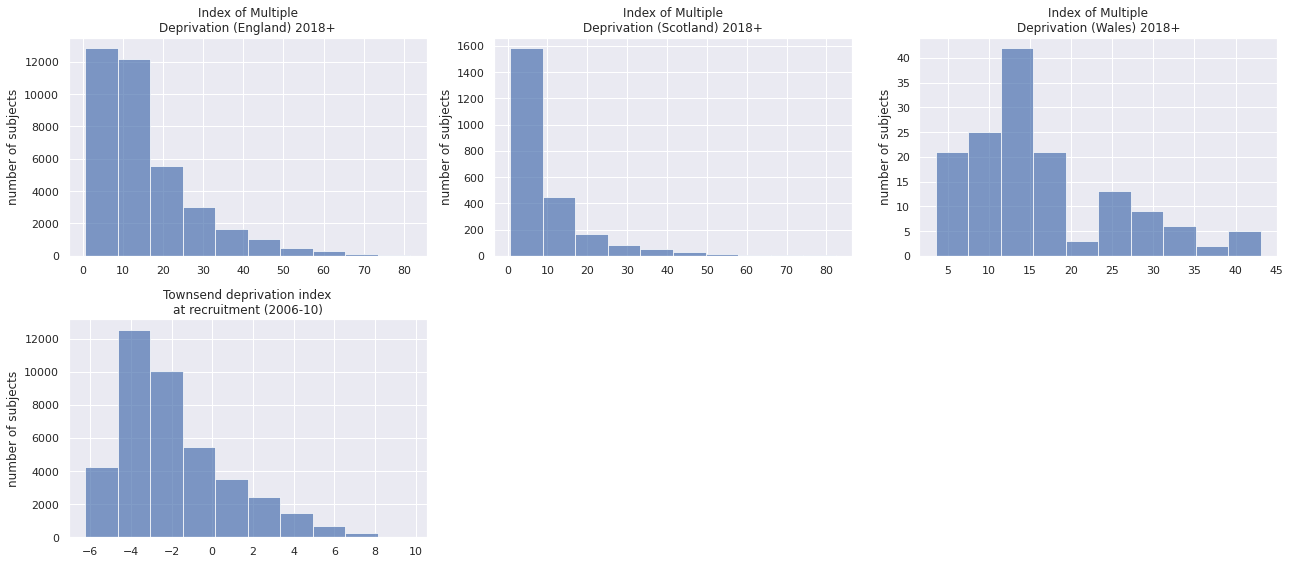

In [19]:
cols_to_plt = {'Index of Multiple Deprivation (England) (s0.0)': 'Index of Multiple Deprivation (England) 2018+',
               'Index of Multiple Deprivation (Scotland) (s0.0)': 'Index of Multiple Deprivation (Scotland) 2018+',
               'Index of Multiple Deprivation (Wales) (s0.0)': 'Index of Multiple Deprivation (Wales) 2018+',
               'Townsend deprivation index at recruitment (s0.0)': 'Townsend deprivation index at recruitment (2006-10)',
               }

#plot
dataset.plot_metadata(df[list(cols_to_plt.keys())].rename(columns=cols_to_plt))
plt.show()

## Health

### ICD diagnosis history

In [7]:
dataset = UKBB2020()
df = dataset.get_metadata(predefined=['icd'], cols=[], print_cols=False)

total subjects in df: 40682


In [8]:
# convert the 150+ columns into a list and drop nan values
df_icd = pd.DataFrame()
df_icd['Diagnoses - all ICD10'] = df.apply(lambda row: np.delete(row.unique(), np.where(row.unique()=='missing')), axis=1)

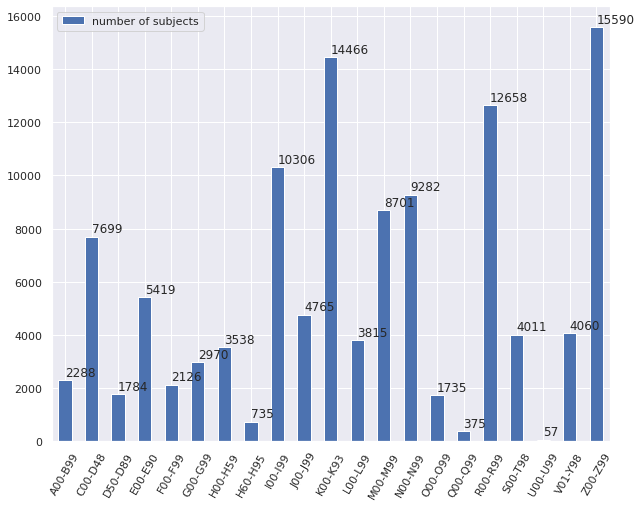

{'A00-B99': 'Certain infectious and parasitic diseases',
 'C00-D48': 'Neoplasms',
 'D50-D89': 'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
 'E00-E90': 'Endocrine, nutritional and metabolic diseases',
 'F00-F99': 'Mental and behavioural disorders',
 'G00-G99': 'Diseases of the nervous system',
 'H00-H59': 'Diseases of the eye and adnexa',
 'H60-H95': 'Diseases of the ear and mastoid process',
 'I00-I99': 'Diseases of the circulatory system',
 'J00-J99': 'Diseases of the respiratory system',
 'K00-K93': 'Diseases of the digestive system',
 'L00-L99': 'Diseases of the skin and subcutaneous tissue',
 'M00-M99': 'Diseases of the musculoskeletal system and connective tissue',
 'N00-N99': 'Diseases of the genitourinary system',
 'O00-O99': 'Pregnancy, childbirth and the puerperium',
 'P00-P96': 'Certain conditions originating in the perinatal period',
 'Q00-Q99': 'Congenital malformations, deformations and chromosomal abnormalities',
 


INFO: subject can have more than 1 ICD10 category.     
Therefore the sum of subjects count in all categories does not equal total subjects
Total instances of Mental and behavioural disorders (F00-F99) = 2126
Total instances of diseases of the nervous system (G00-G99) = 2970
Further details about each category can be found at http://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=41202


In [9]:
counts = plotIcd10Distribution(df_icd, mapICDParents, threshold=50)
plt.show()
display(ICD10map)
print("\nINFO: subject can have more than 1 ICD10 category. \
    \nTherefore the sum of subjects count in all categories does not equal total subjects")
print("Total instances of Mental and behavioural disorders (F00-F99) =", counts['F00-F99'])
print("Total instances of diseases of the nervous system (G00-G99) =", counts['G00-G99'])
print("Further details about each category can be found at http://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=41202")

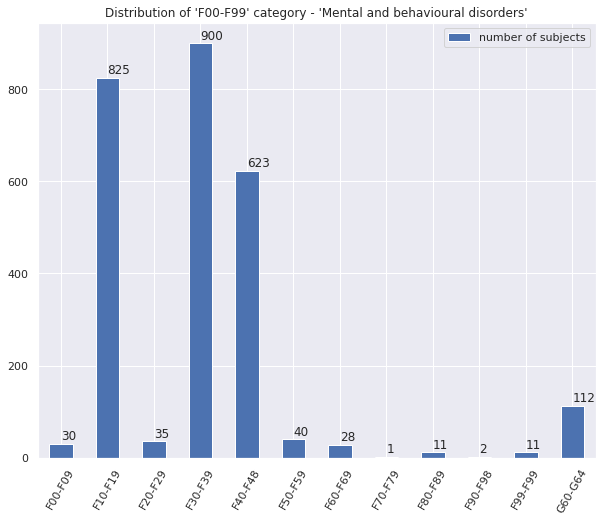

{'F00-F09': 'Organic, including symptomatic, mental disorders',
 'F10-F19': 'Mental and behavioural disorders due to psychoactive substance use',
 'F20-F29': 'Schizophrenia, schizotypal and delusional disorders',
 'F30-F39': 'Mood [affective] disorders',
 'F40-F48': 'Neurotic, stress-related and somatoform disorders',
 'F50-F59': 'Behavioural syndromes associated with physiological disturbances and physical factors',
 'G60-G64': 'Polyneuropathies and other disorders of the peripheral nervous system',
 'F60-F69': 'Disorders of adult personality and behaviour',
 'F70-F79': 'Mental retardation',
 'F80-F89': 'Disorders of psychological development',
 'F90-F98': 'Behavioural and emotional disorders with onset usually occurring in childhood and adolescence',
 'F99-F99': 'Unspecified mental disorder'}

In [10]:
_ = plotIcd10Distribution(df_icd, mapFCategory, 
                          title="Distribution of 'F00-F99' category - 'Mental and behavioural disorders'")
plt.show()
ICD10_F_map

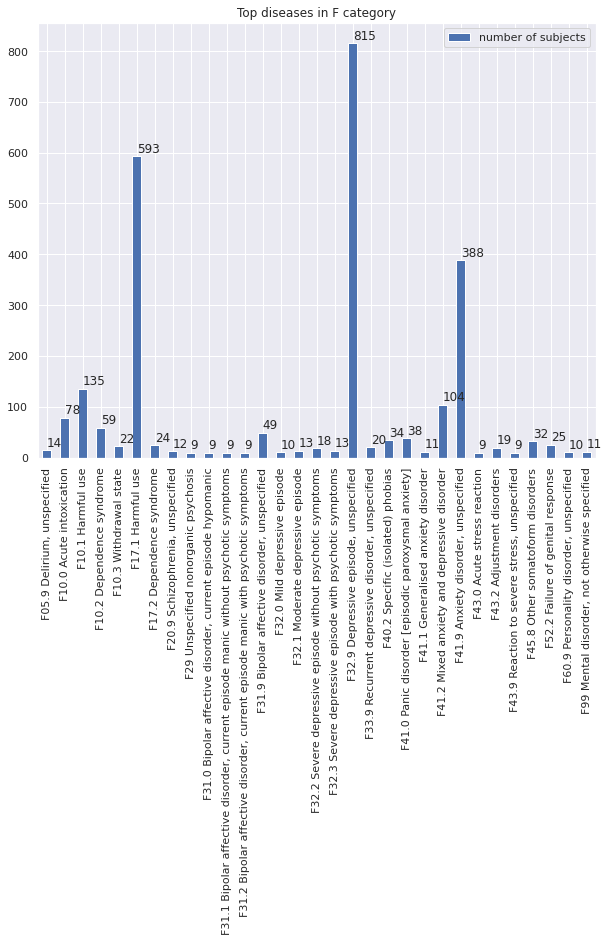

In [11]:
_ = plotIcd10Distribution(df_icd, lambda x: x if (getICDVal(x[:3]) in getICDRange('F00-F99')) else None, 
                      title= "Top diseases in F category", rot=90, 
                      threshold=7)

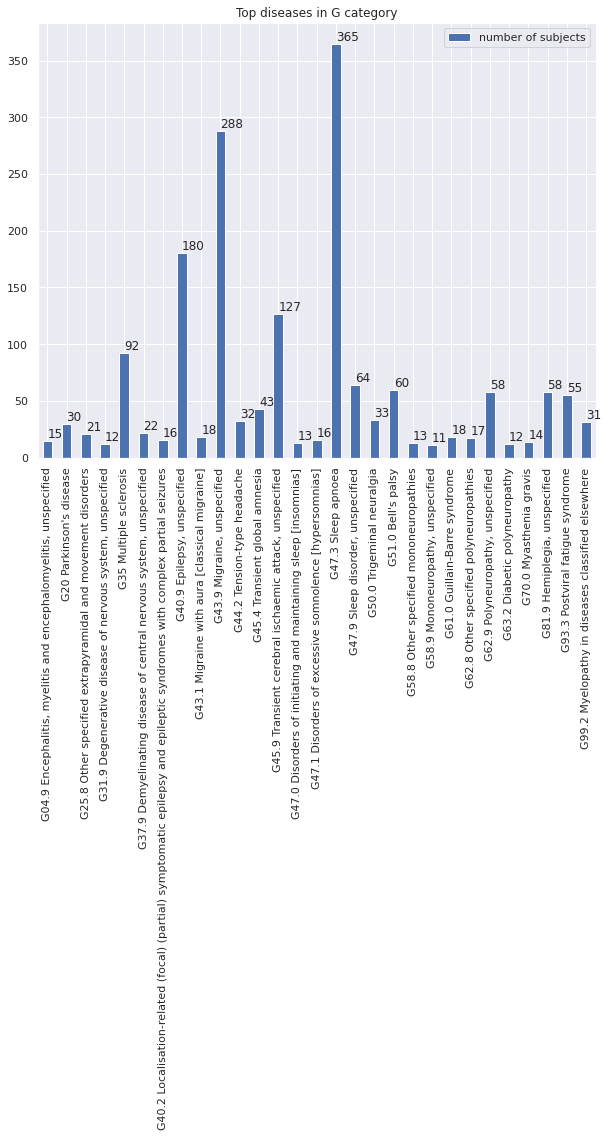

In [12]:
_ = plotIcd10Distribution(df_icd, lambda x: x if (getICDVal(x[:3]) in getICDRange('G00-G99')) else None, 
                      title= "Top diseases in G category", rot=90, 
                      exclude_cats=['carpal', 'nerve', 'limb'], threshold=10)

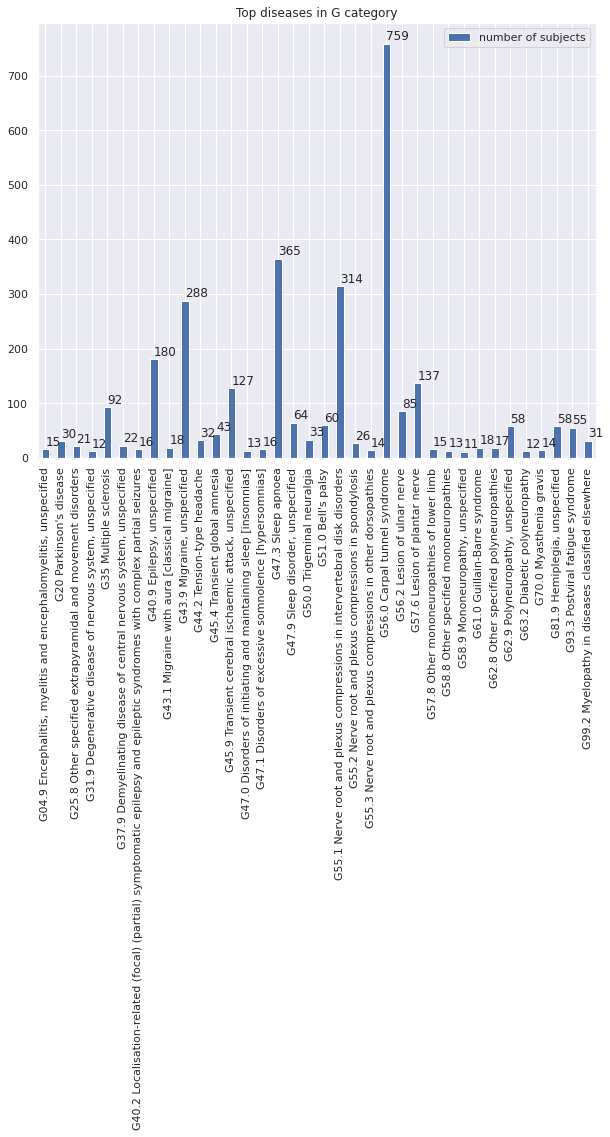

In [13]:
_ = plotIcd10Distribution(df_icd, lambda x: x if (getICDVal(x[:3]) in getICDRange('G00-G99')) else None, 
                      title= "Top diseases in G category", rot=90, 
                      exclude_cats=[], threshold=10)

### Physical health
Sources:
  - Touchscreen questionnaire on lifestyle and personal exposures https://biobank.ndph.ox.ac.uk/showcase/label.cgi?id=100050 

In [26]:
dataset = UKBB2020()
df = dataset.get_metadata(predefined=['physical_health'], cols=[])

subjects in df: 40682
subjects in df_holdout: 0
loaded following columns:
 {'21001-2.0': 'Body mass index (BMI)', '4079-2.0': 'Diastolic blood pressure, automated reading', '4080-2.0': 'Systolic blood pressure, automated reading', '30690-0.0': 'Cholesterol (s0.0)', '30690-1.0': 'Cholesterol (s1.0)', '22040-0.0': 'Summed MET minutes per week for all activity (s0.0)'}


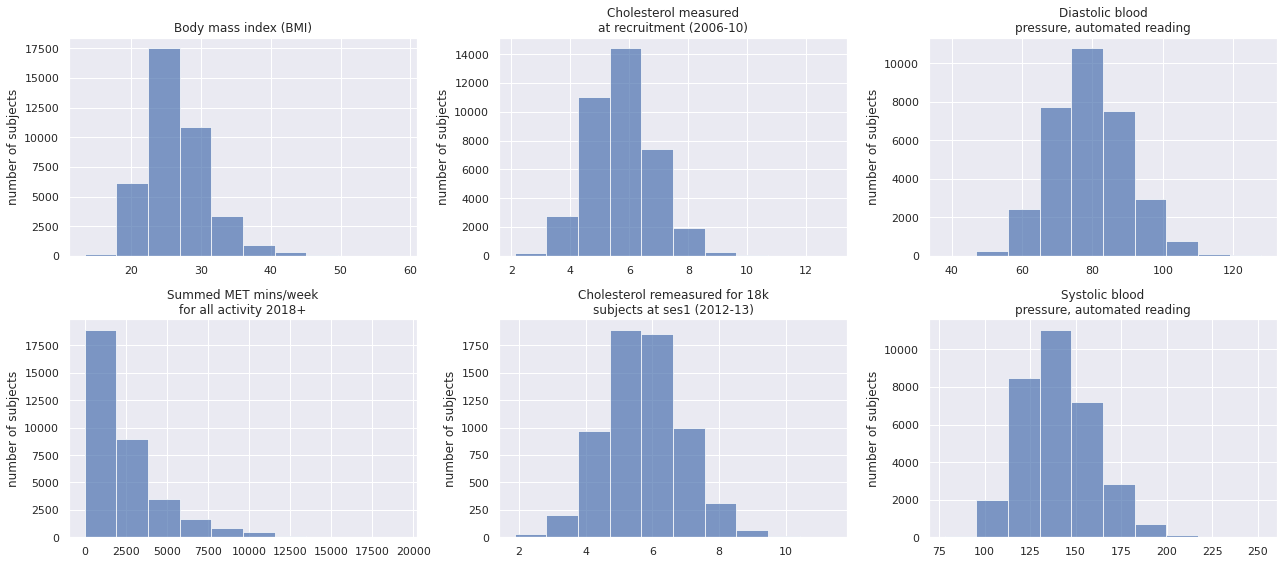

In [27]:
cols_to_plt = {'Body mass index (BMI)': 'Body mass index (BMI)',
               'Cholesterol (s0.0)': 'Cholesterol measured at recruitment (2006-10)',
               'Diastolic blood pressure, automated reading': 'Diastolic blood pressure, automated reading',
               'Summed MET minutes per week for all activity (s0.0)': 'Summed MET mins/week for all activity 2018+',
               'Cholesterol (s1.0)': 'Cholesterol remeasured for 18k subjects at ses1 (2012-13)',
               'Systolic blood pressure, automated reading': 'Systolic blood pressure, automated reading',
               }
#plot
dataset.plot_metadata(df[list(cols_to_plt.keys())].rename(columns=cols_to_plt))
plt.show()

### Mental health: self-report
Sources:
  - Online self-assessment questionnaire issued in 2016/08 to 2017/02 - one question each from the categories of https://biobank.ndph.ox.ac.uk/showcase/label.cgi?id=136

In [28]:
df = dataset.get_metadata(predefined=['mental_health'])

loaded following columns:
 {'20499-0.0': 'Ever sought or received professional help for mental distress (s0.0)', '20446-0.0': 'Ever had prolonged feelings of sadness or depression (s0.0)', '20510-0.0': 'Recent feelings of depression (s0.0)', '20501-0.0': 'Ever had period of mania / excitability (s0.0)', '20421-0.0': 'Ever felt worried, tense, or anxious for most of a month or longer (s0.0)', '20506-0.0': 'Recent feelings or nervousness or anxiety (s0.0)', '20401-0.0': 'Ever addicted to any substance or behaviour (s0.0)', '20526-0.0': 'Been in serious accident believed to be life-threatening (s0.0)', '20489-0.0': 'Felt loved as a child (s0.0)', '20525-0.0': 'Able to pay rent/mortgage as an adult (s0.0)', '20480-0.0': 'Ever self-harmed (s0.0)', '20485-0.0': 'Ever contemplated self-harm (s0.0)', '20460-0.0': 'Belief that own life is meaningful (s0.0)', '20458-0.0': 'General happiness (s0.0)'}


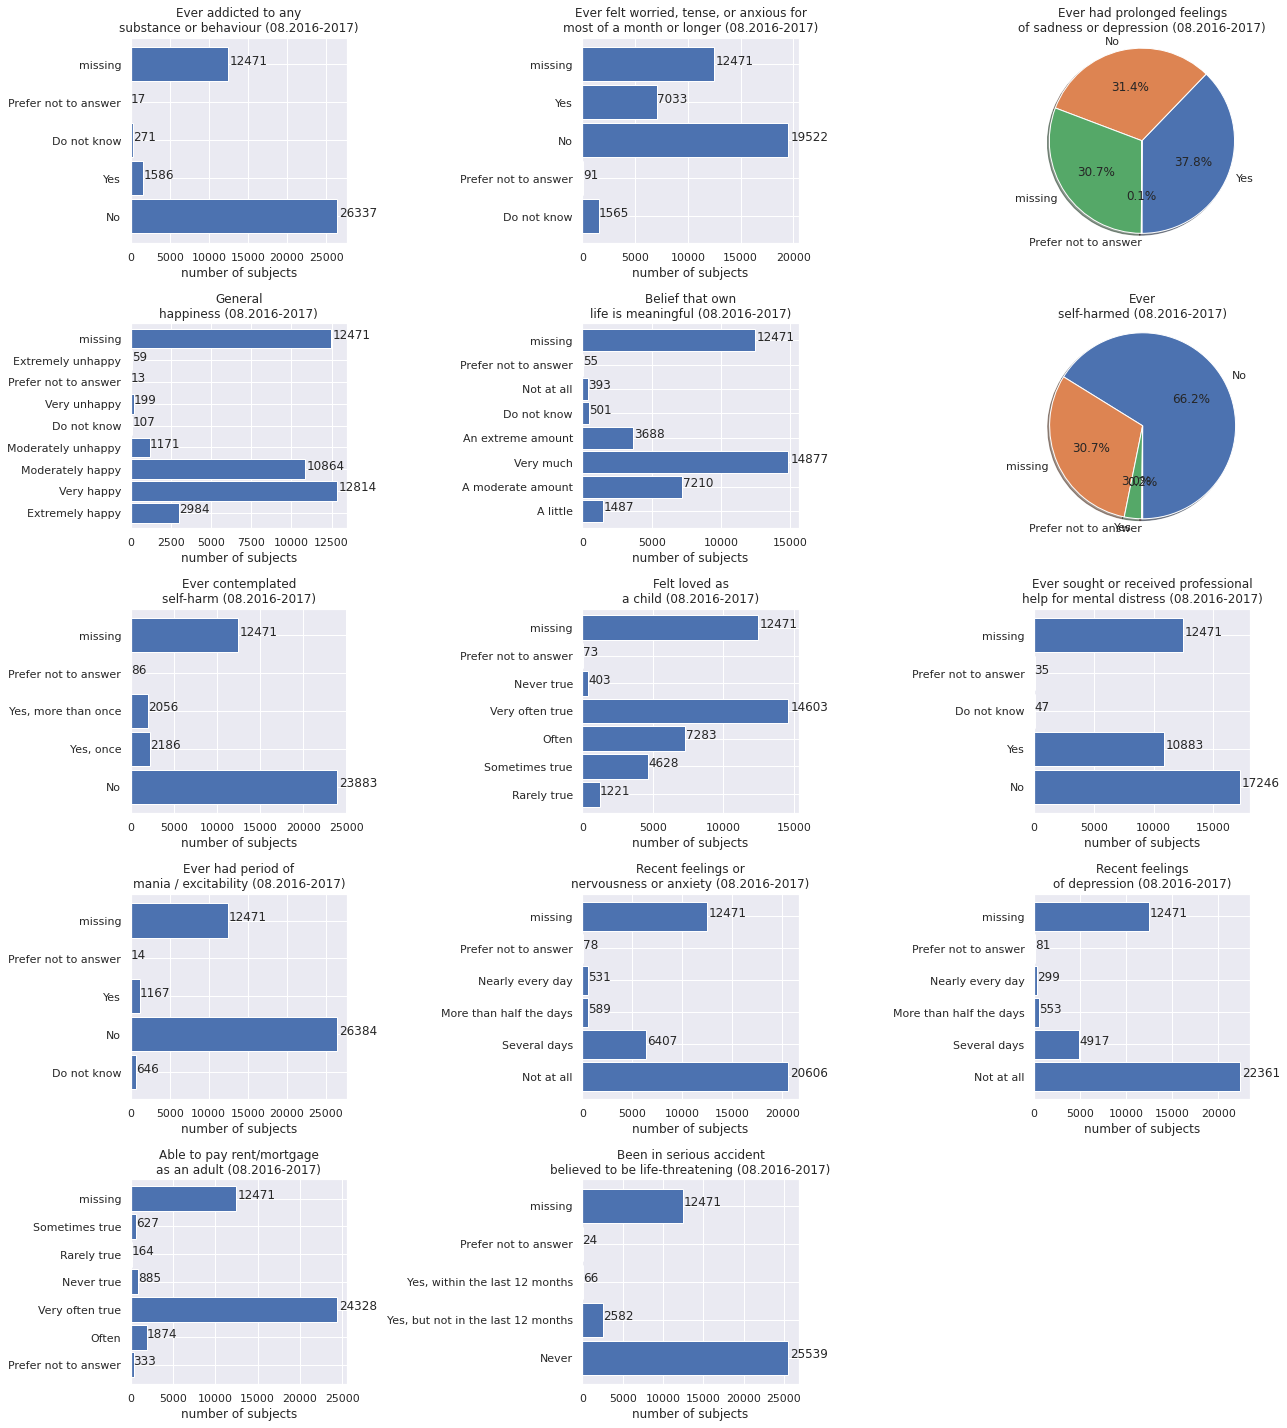

In [29]:
cols_to_plt = {col: col.replace('(s0.0)', '(08.2016-2017)')  for col in df.columns}
dataset.plot_metadata(df[list(cols_to_plt.keys())].rename(columns=cols_to_plt))
plt.show()

#### Substance use
Indepth look into alcohol and other substance addictions

In [30]:
dataset = UKBB2020()
df = dataset.get_metadata(predefined=['alcohol'], split='train')

subjects in df: 40682
subjects in df_holdout: 0
loaded following columns:
 {'1558-2.0': 'Alcohol intake frequency.', '20415-0.0': 'Ongoing addiction to alcohol (s0.0)', '20117-2.0': 'Alcohol drinker status', '2664-2.0': 'Reason for reducing amount of alcohol drunk', '20414-0.0': 'Frequency of drinking alcohol (s0.0)', '20403-0.0': 'Amount of alcohol drunk on a typical drinking day (s0.0)', '20416-0.0': 'Frequency of consuming six or more units of alcohol (s0.0)', '20413-0.0': 'Frequency of inability to cease drinking in last year (s0.0)', '20407-0.0': 'Frequency of failure to fulfil normal expectations due to drinking alcohol in last year (s0.0)', '20412-0.0': 'Frequency of needing morning drink of alcohol after heavy drinking session in last year (s0.0)', '20409-0.0': 'Frequency of feeling guilt or remorse after drinking alcohol in last year (s0.0)', '20408-0.0': 'Frequency of memory loss due to drinking alcohol in last year (s0.0)', '20411-0.0': 'Ever been injured or injured someone 

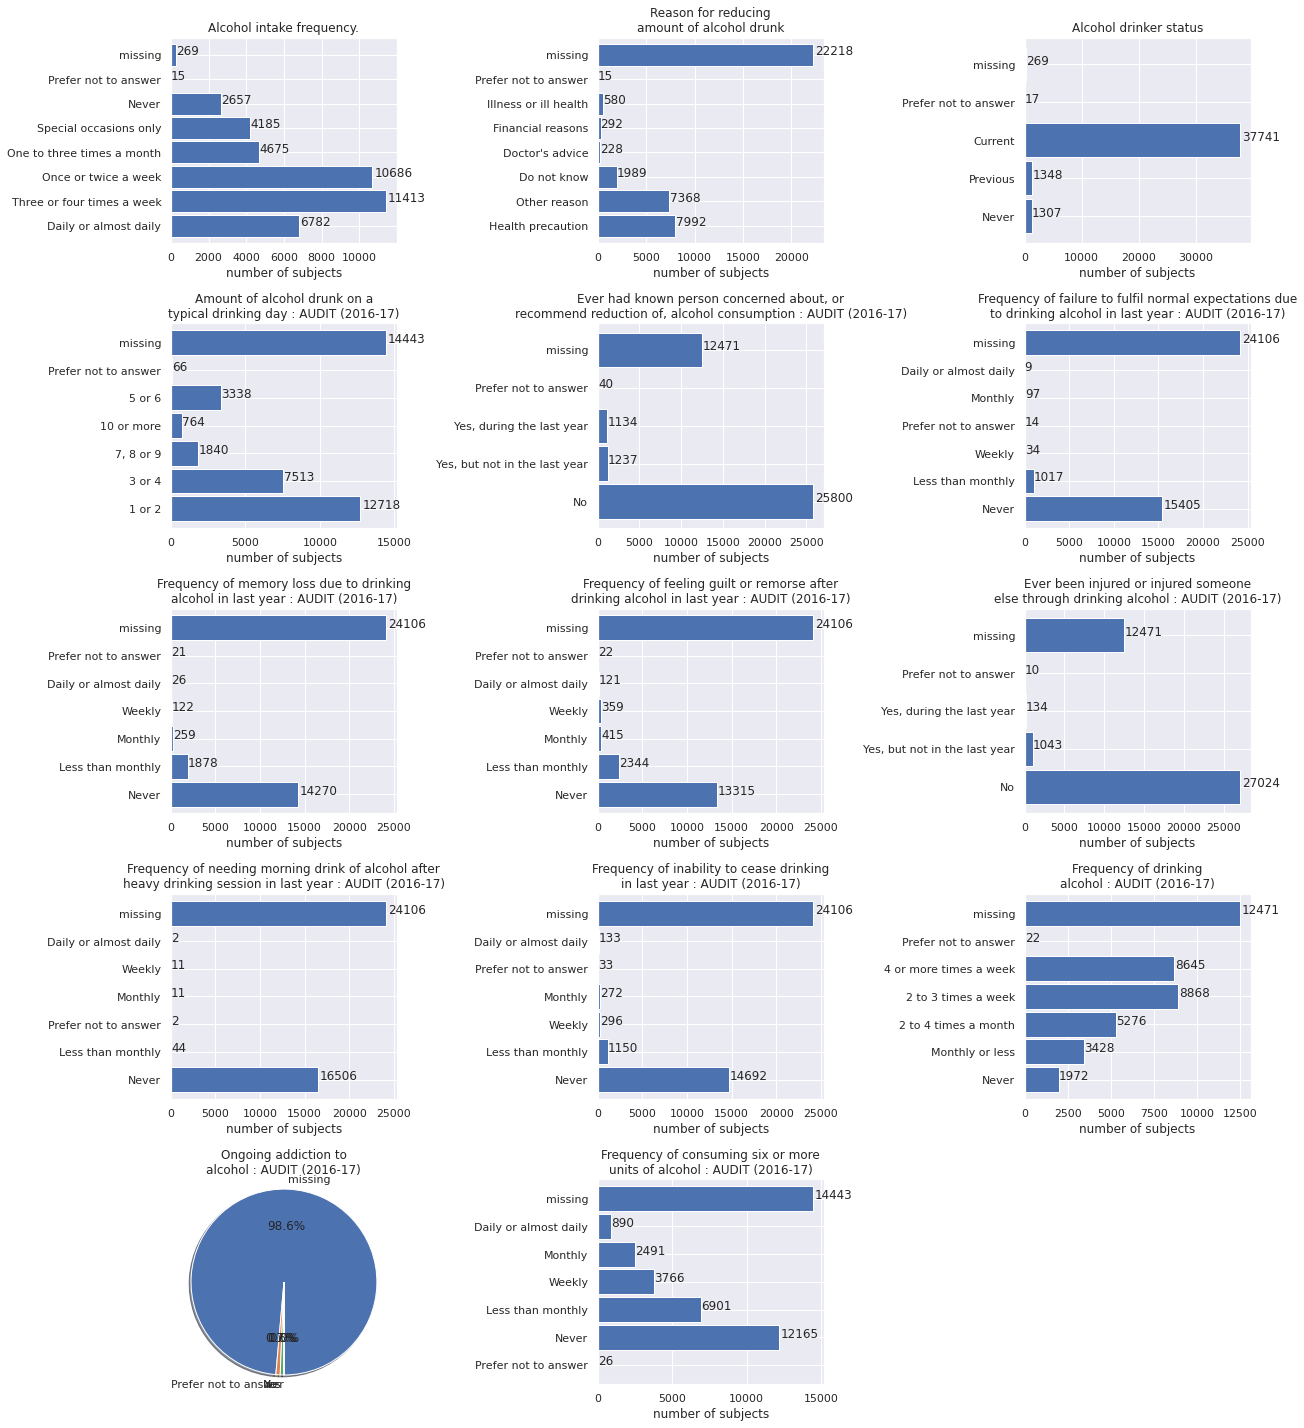

In [31]:
cols_to_plt = {col: col.replace('(s0.0)', ': AUDIT (2016-17)')  for col in df.columns}
dataset.plot_metadata(df[list(cols_to_plt.keys())].rename(columns=cols_to_plt))
plt.show()

In [32]:
df = dataset.get_metadata(predefined=["other-substance"])

loaded following columns:
 {'1239-2.0': 'Current tobacco smoking', '3456-2.0': 'Number of cigarettes currently smoked daily (current cigarette smokers)', '20454-0.0': 'Maximum frequency of taking cannabis (s0.0)'}


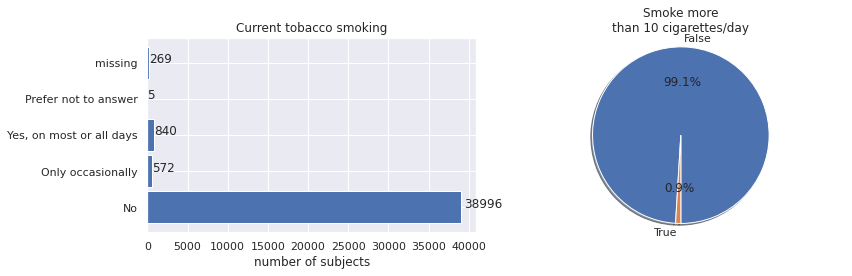

In [33]:
df['Smoke more than 10 cigarettes/day'] = df['Number of cigarettes currently smoked daily (current cigarette smokers)']>10

cols_to_plt = {'Current tobacco smoking': 'Current tobacco smoking',
               'Smoke more than 10 cigarettes/day': 'Smoke more than 10 cigarettes/day'}

dataset.plot_metadata(df[list(cols_to_plt.keys())].rename(columns=cols_to_plt))
plt.show()

## Data collection Timelines
- 4 sessions have been done so far: Click on '4 Instances' tab in https://biobank.ctsu.ox.ac.uk/crystal/field.cgi?id=53
- Imaging data used in this analysis belongs to assessment 2.0 that started from 2014+
- However, the self-report questionnaires have been taken at a different time (during first recruitment in 2006-10 or later during 3rd session in 2018+). 
- The ICD diagnosis might have occured at a different period of their life, much before assessment 2.0.

In [34]:
dataset = UKBB2020()
df = dataset.get_metadata(predefined=[], cols=['20400-*', '53-.*.0'])

subjects in df: 40682
subjects in df_holdout: 0
loaded following columns:
 {'20400-0.0': 'Date of completing mental health questionnaire (s0.0)', '53-0.0': 'Date of attending assessment centre (s0.0)', '53-1.0': 'Date of attending assessment centre (s1.0)', '53-2.0': 'Date of attending assessment centre', '53-3.0': 'Date of attending assessment centre (s3.0)'}


In [35]:
# add the ICD diagnosis dates for F and G too as a new column
# first determine which ICD columns have F and G category diseases
df_icd_date = dataset.get_metadata(predefined=['icd'], cols=['41280-*'], rename_cols=False, print_cols=False) 
mask = df_icd_date.filter(regex='41270', axis=1)
mask = mask.applymap(lambda x: ('F' in x) or ('G20' in x) or ('G30' in x) or ('G35' in x) or ('G4' in x),
                     na_action='ignore').fillna(False).rename(columns=lambda c: c.replace('270', '280'))

In [36]:
# extract all valid dates of diagnosis for subjects with ICD10.F and ICD10.G conditions from '41280-*'
icd_all_dates = pd.Series(np.unique(df_icd_date.filter(regex='41280', axis=1)[mask].to_numpy().reshape(-1)))
icd_all_dates =icd_all_dates[~icd_all_dates.isnull()] # drop NaT

In [37]:
# df.value_counts().sort_index().resample("M").sum().to_period().plot.bar()
# convert all dates into just months
df_dates = pd.DataFrame(index=pd.date_range(icd_all_dates.min(), df.max().max(), freq='D').to_period())

for c in df:
    df_dates[c] = df[c].value_counts().resample("D").sum().to_period()

cols_to_plt = {'Date of completing mental health questionnaire (s0.0)': 'Date of completing mental health questionnaire',
               'Date of attending assessment centre (s0.0)': 'Recruitement and assessment 0.0',
               'Date of attending assessment centre (s1.0)': 'First repeat assessment (assessment 1.0)',
               'Date of attending assessment centre': 'Date of imaging (assessment 2.0)',
               'Date of attending assessment centre (s3.0)': 'Repeat imaging (assessment 3.0)',
              }
df_dates = df_dates[cols_to_plt.keys()].rename(columns=cols_to_plt)

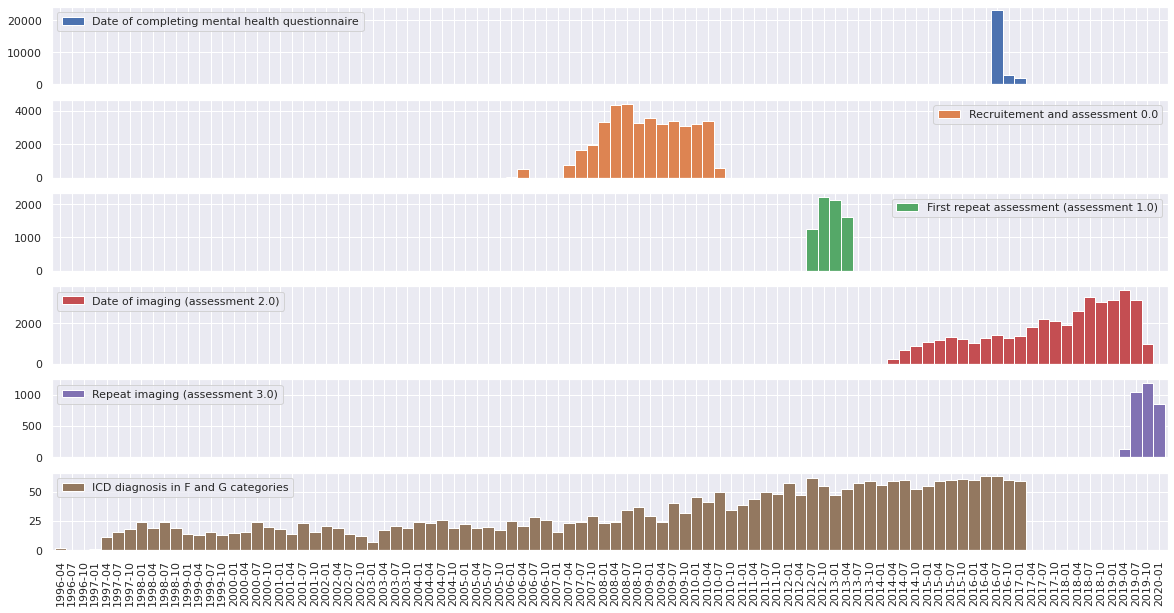

In [38]:
# append to df_dates
df_dates['ICD diagnosis in F and G categories'] = icd_all_dates.dt.to_period('D').value_counts()

# show over periods of 3months
df_dates.resample("3M").sum().plot.bar(figsize=(20,10), width=1, subplots=True, title=['']*len(df_dates.columns))
plt.show()

Misl helper functions

In [39]:
# # # convert tables from webiste to column numbers"
# st = """
# 20414	Frequency of drinking alcohol
# 20403	Amount of alcohol drunk on a typical drinking day
# 20416	Frequency of consuming six or more units of alcohol
# 20413	Frequency of inability to cease drinking in last year
# 20407	Frequency of failure to fulfil normal expectations due to drinking alcohol in last year
# 20412	Frequency of needing morning drink of alcohol after heavy drinking session in last year
# 20409	Frequency of feeling guilt or remorse after drinking alcohol in last year
# 20408	Frequency of memory loss due to drinking alcohol in last year
# 20411	Ever been injured or injured someone else through drinking alcohol
# 20405	Ever had known person concerned about, or recommend reduction of, alcohol consumption
# 20410	Age when known person last commented about drinking habits
# """

# cols = ["{}-0.0".format(sti.split('\t')[0]) for sti in st.split("\n")]
# for _ in range(len(cols)):
#     if '-0.0' in cols: 
#         cols.remove('-0.0')
# print(str(cols).replace("'", '"'))